### setup

In [ ]:
%pip install -r requirements.txt

: 

## COLLECT DATA

### collect market data using binance api


In [4]:
from binance.client import Client

client = Client()
exchange_info = client.get_exchange_info()

print(f"market info: {len(exchange_info['symbols'])}")


market info: 2873


### fetch curent market data for all trading pairs which would later be filtered

In [5]:
import pandas as pd

tickers = client.get_ticker()
tickers_df = pd.DataFrame(tickers).set_index('symbol')
tickers_df['quoteVolume'] = pd.to_numeric(tickers_df['quoteVolume'])

print(tickers_df.head(5))

         priceChange priceChangePercent weightedAvgPrice prevClosePrice  \
symbol                                                                    
ETHBTC    0.00055000              1.506       0.03683607     0.03651000   
LTCBTC    0.00000300              0.266       0.00114347     0.00112700   
BNBBTC    0.00001700              0.234       0.00730905     0.00725100   
NEOBTC   -0.00000030             -0.185       0.00016398     0.00016220   
QTUMETH  -0.00001500             -1.567       0.00095597     0.00096100   

          lastPrice      lastQty    bidPrice       bidQty    askPrice  \
symbol                                                                  
ETHBTC   0.03707000   0.59130000  0.03706000  42.66240000  0.03707000   
LTCBTC   0.00112900   1.43000000  0.00112900   3.23200000  0.00113000   
BNBBTC   0.00726700   0.02800000  0.00726600   0.45200000  0.00726700   
NEOBTC   0.00016210  10.52000000  0.00016210  24.59000000  0.00016220   
QTUMETH  0.00094200  39.20000000  0.

### setup cache and data directories for data collected

In [6]:
import os


cache_dir = "./.cache"
data_dir = "./data"

os.makedirs(cache_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

In [7]:
from os import makedirs


cache_dir = "./.cache"
data_dir = "./data"
makedirs(cache_dir, exist_ok=True)
makedirs(data_dir, exist_ok=True)

### setup cache and make requests in batches 
- to avoid rate limiting
- to speed up the process
- to avoid redundant requests


In [8]:
from joblib import Memory

memory = Memory(cache_dir)

BATCH_SIZE = 30
SLEEP_TIME = 1


### filter market data
why these filters?
- MAX_DAYS: to avoid data that is too old (90 days)
- MIN_VOLUME: to avoid data that is too low (50,000 USDT)
- MAX_VOLUME: to avoid data that is too high (10,000,000 USDT)
- MIN_MARKET_CAP: to avoid data that is too low (1,000,000 USDT)
- MAX_MARKET_CAP: to avoid data that is too high (100,000,000 USDT) as requested in the assigment


In [9]:
MARKET_FILTERS = {
    'MAX_DAYS': 90,
    'MIN_VOLUME': 50_000,
    'MAX_VOLUME': 10_000_000,
    'MIN_MARKET_CAP': 1_000_000,
    'MAX_MARKET_CAP': 100_000_000
}

### filter market data for USDT pairs and volume

In [10]:
@memory.cache
def get_klines_cached(symbol, interval, limit):
    return client.get_klines(symbol=symbol, interval=interval, limit=limit)

# filter USDT pairs
valid_pairs = pd.DataFrame(exchange_info['symbols'])
valid_pairs = valid_pairs[
    (valid_pairs['symbol'].str.endswith('USDT')) & 
    (valid_pairs['status'] == 'TRADING')
]['symbol']

# filter by volume
volume_mask = tickers_df['quoteVolume'].between(50_000, 10_000_000)
filtered_pairs = tickers_df[tickers_df.index.isin(valid_pairs) & volume_mask]

print(f"Found {len(filtered_pairs)} pairs meeting initial criteria")

Found 266 pairs meeting initial criteria


### collect eligible symbols in batches
for each potential symbol:
- check token age(days) using klines
- calculate market cap
- filter market cap
- collect data

In [11]:
import time

candidates_data = []

# split symbols into batches
symbols = list(filtered_pairs.index)
batches = [symbols[i:i + BATCH_SIZE] for i in range(0, len(symbols), BATCH_SIZE)]

for batch in batches:
    for symbol in batch:
        try:
            klines = get_klines_cached(symbol, "1d", 90)
            if not klines or len(klines) >= 90:
                continue
                
            ticker = filtered_pairs.loc[symbol]
            market_cap = float(ticker.get('marketCap', float(ticker['quoteVolume']) * 7))
            
            if not (1_000_000 <= market_cap <= 100_000_000):
                continue

            candidates_data.append({
                'symbol': symbol,
                'days_listed': len(klines),
                'market_cap': market_cap,
                'volume_24h': ticker['quoteVolume']
            })

        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    time.sleep(SLEEP_TIME)

candidates_df = pd.DataFrame(candidates_data).set_index('symbol')
print(f"Found {len(candidates_df)} final candidates")

________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached('NEOUSDT', '1d', 90)
________________________________________________get_klines_cached - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached('QTUMUSDT', '1d', 90)
________________________________________________get_klines_cached - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached('TUSDUSDT', '1d', 90)
________________________________________________get_klines_cached - 0.4s, 0.0min
____________________________________________

### collect historical data on eligible symbols


#### time frame choice:
- the proposed 10m time frame for granularity could not be fetched since Binance API doesn't support it.
- the closest granularity that can be fetched is 15m
- data collected should be sufficient for the training of the model


In [12]:
historical_data = {}

for symbol in candidates_df.index:
    try:
        klines = get_klines_cached(
            symbol=symbol,
            interval='15m',
            limit=MARKET_FILTERS['MAX_DAYS'] * 24
        )

        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_volume', 'trades',
            'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
        ])

        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        
        for col in df.columns:
            if col not in ['close_time', 'ignore']:
                df[col] = pd.to_numeric(df[col])

        historical_data[symbol] = df

    except Exception as e:
        print(f"Error fetching history for {symbol}: {str(e)}")

________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached(symbol='BNSOLUSDT', interval='15m', limit=2160)
________________________________________________get_klines_cached - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached(symbol='LUMIAUSDT', interval='15m', limit=2160)
________________________________________________get_klines_cached - 0.6s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-3674610942.get_klines_cached...
get_klines_cached(symbol='KAIAUSDT', interval='15m', limit=2160)
_______________________________________________

## FEATURE ENGINEERING

In [13]:
from dataclasses import dataclass

@dataclass
class Features:
    price_ma_windows: tuple[int, ...] = (7, 14, 21)
    vol_ma_windows: tuple[int, ...] = (7, 14, 21)
    volatility_window: int = 14
    rsi_window: int = 14
    bb_window: int = 20
    bb_std: float = 2.0
    macd_fast: int = 12
    macd_slow: int = 26
    macd_signal: int = 9

params = Features()

### calculate features

In [19]:
import numpy as np
# df = pd.DataFrame.from_dict(historical_data)

# print("type:", type(historical_data))

# if isinstance(historical_data, dict):
#     fk = list(historical_data.keys())[0]
#     print("check value:", historical_data[fk])

feature_dfs = {}

# Feature selection based on correlation analysis and distributions
for symbol, df in historical_data.items():
    print(f"preprocessing {symbol}...")
    features = pd.DataFrame(index=df.index)
    
    # 1. returns - key independent signal, normal distribution
    # essentially, capture the price movement
    features['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # 2. volatility - independent signal with regime information
    ranges = pd.concat([
        df['high'] - df['low'],
        (df['high'] - df['close'].shift(1)).abs(),
        (df['low'] - df['close'].shift(1)).abs()
    ], axis=1)
    features['volatility'] = ranges.max(axis=1).rolling(params.volatility_window).mean()
    
    # 3. volume - independent signal with low correlation
    volume_ma = df['volume'].rolling(params.vol_ma_windows[0]).mean()
    features['volume_intensity'] = df['volume'] / volume_ma
    
    # 4. trend - select only one MA period to avoid redundancy
    # using 14-period MA as it balances short and long term
    ma_14 = df['close'].rolling(14).mean()
    features['price_ma_14'] = df['close'] / ma_14 - 1
    
    # 5. rsi - momentum indicator with good distribution
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(params.rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(params.rsi_window).mean()
    features['rsi'] = 100 - (100 / (1 + gain / loss))
    
    # 6. bollinger bands - keeping only upper band as lower is highly correlated
    ma = df['close'].rolling(params.bb_window).mean()
    std = df['close'].rolling(params.bb_window).std()
    features['bb_upper'] = (df['close'] - (ma + params.bb_std * std)) / df['close']
    
    feature_dfs[symbol] = features.dropna()

for symbol, features in feature_dfs.items():
    print(f"\n{symbol}:")
    print(f"shape: {features.shape}")
    print("features:", features.columns.tolist())
    print("\nfirst few rows:")
    print(features.head())
    break 

preprocessing BNSOLUSDT...
preprocessing LUMIAUSDT...
preprocessing KAIAUSDT...
preprocessing ORCAUSDT...
preprocessing VELODROMEUSDT...

BNSOLUSDT:
Shape: (981, 6)
Features: ['returns', 'volatility', 'volume_intensity', 'price_ma_14', 'rsi', 'bb_upper']

First few rows:
                      returns  volatility  volume_intensity  price_ma_14  \
timestamp                                                                  
2024-12-25 13:15:00  0.000497    1.300000          0.069660    -0.002055   
2024-12-25 13:30:00  0.000497    1.257143          0.850093    -0.001099   
2024-12-25 13:45:00  0.000993    1.121429          0.392542     0.000709   
2024-12-25 14:00:00  0.004951    1.107143          0.992971     0.005961   
2024-12-25 14:15:00  0.001480    1.014286          0.866136     0.007166   

                           rsi  bb_upper  
timestamp                                 
2024-12-25 13:15:00  45.238095 -0.012496  
2024-12-25 13:30:00  41.772152 -0.011653  
2024-12-25 13:45:00  33

### visualize feature selection
sample analysis on the first symbol

### correlation heatmap
initially, we will look at the correlation between features for a single symbol.

thoughts on feature selection:
- returns and volatility are highly correlated
- volume intensity and returns are weakly correlated
- rsi and returns are weakly correlated
- bb upper and returns are weakly correlated
  
it appears that the features set is well balanced and captures the price movement, volatility, volume, and momentum.


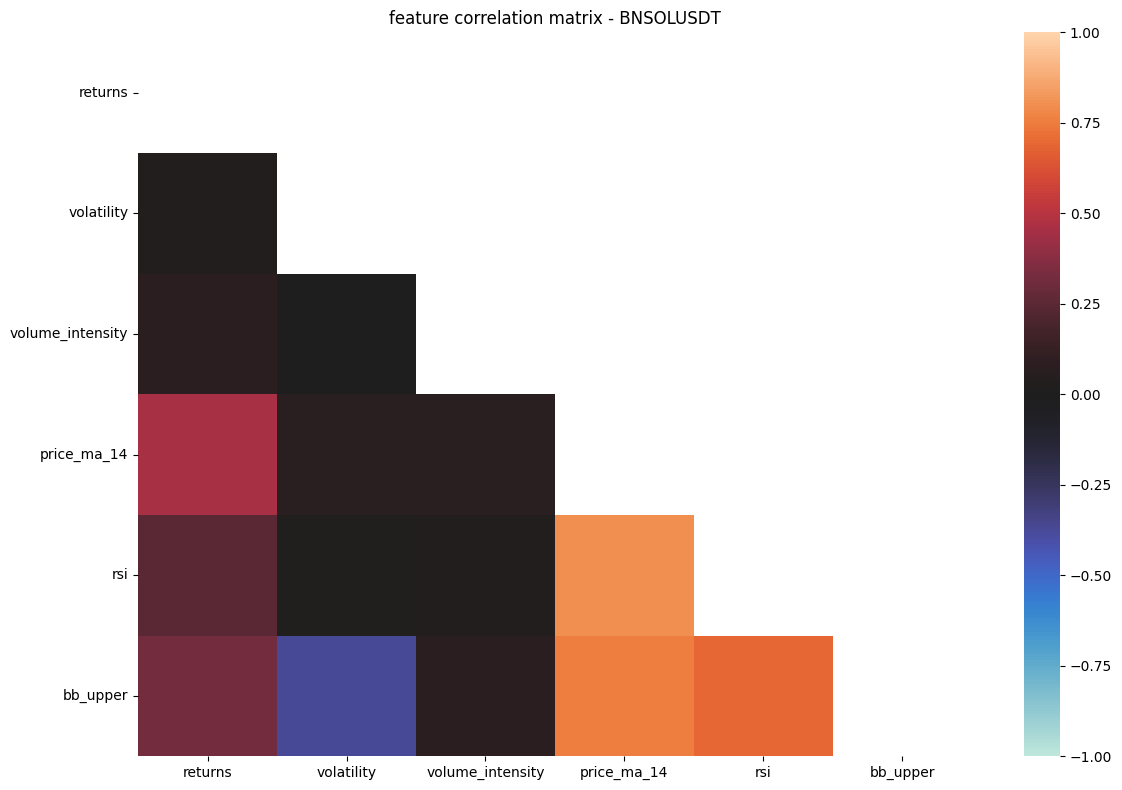

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


symbol = list(feature_dfs.keys())[0]  # first symbol
features = feature_dfs[symbol]

# correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), 
    mask=np.triu(np.ones_like(features.corr(), dtype=bool)),  # show lower triangle
    vmin=-1, vmax=1,
    center=0)
    
plt.title(f'feature correlation matrix - {symbol}')
plt.tight_layout()
plt.show()



### feature distributions
thoughts on feature distributions:
- returns are normally distributed
- volatility is skewed to the right
- volume intensity is skewed to the right
- price ma 14 is skewed to the right
- rsi is skewed to the right
- bb upper is skewed to the right

in all, the distributions are well balanced and meets expected financial metrics

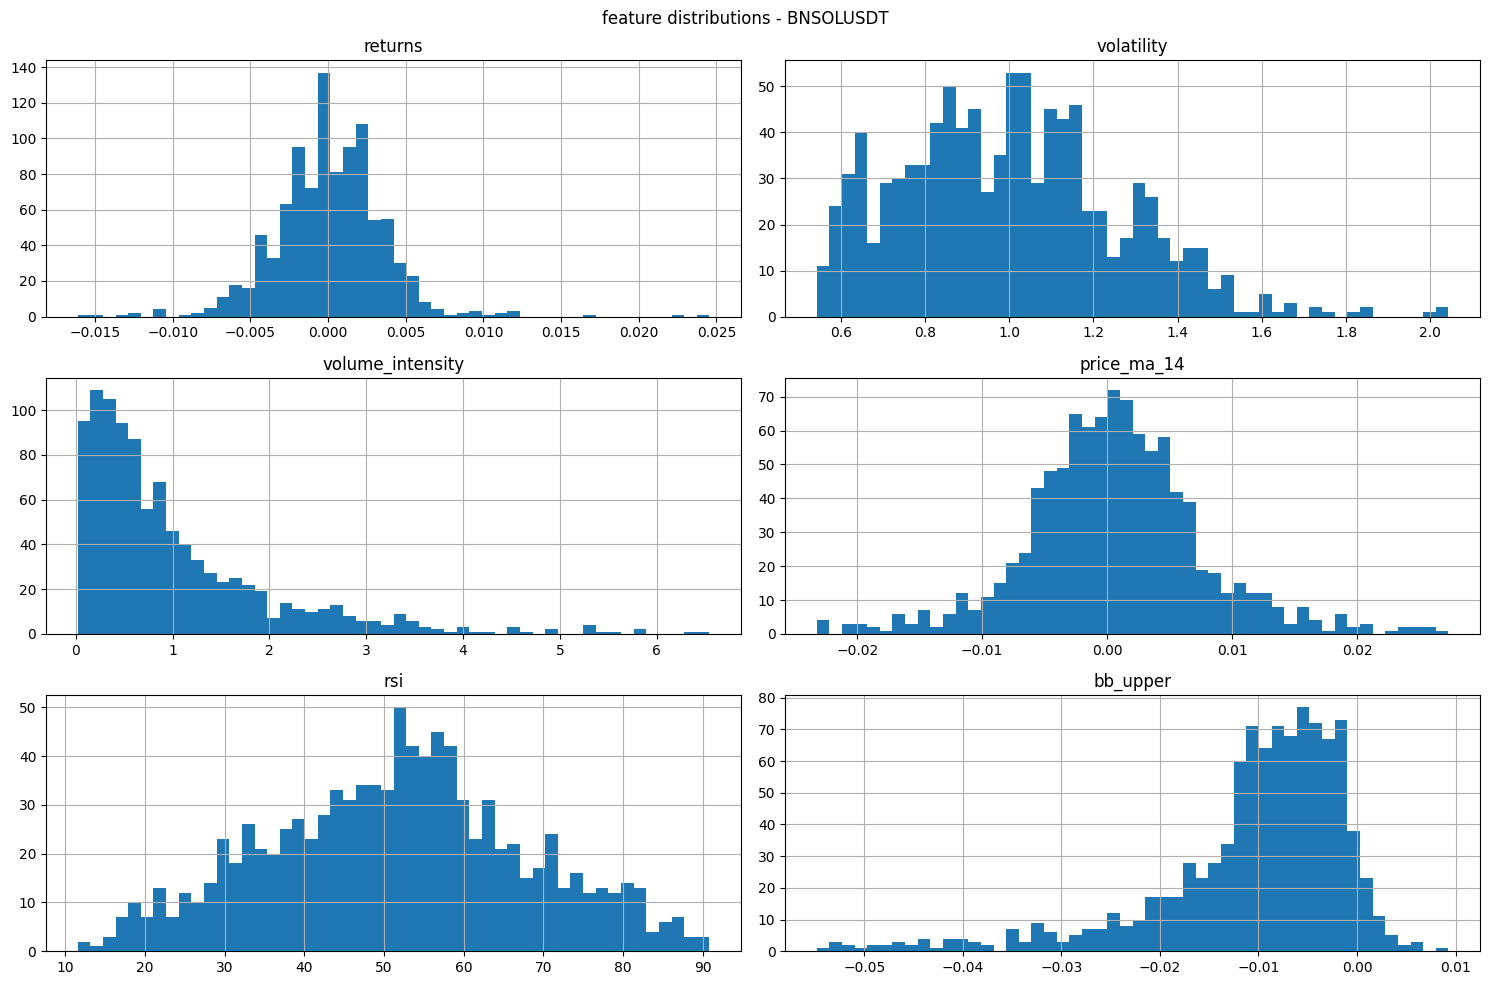

In [23]:
# feature distributions
features.hist(figsize=(15, 10), bins=50)
plt.suptitle(f'feature distributions - {symbol}')
plt.tight_layout()
plt.show()